In [8]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import time
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# Tải dữ liệu NLTK
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
except:
    pass

# Thử import Sentence Transformers
try:
    from sentence_transformers import SentenceTransformer
    EMBEDDINGS_AVAILABLE = True
    print("Sentence Transformers có sẵn")
except ImportError:
    EMBEDDINGS_AVAILABLE = False
    print("Sentence Transformers không có sẵn")

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")
print("Đã import thành công tất cả thư viện cần thiết")

Sentence Transformers có sẵn
Đã import thành công tất cả thư viện cần thiết


THÔNG TIN CƠ BẢN VỀ DỮ LIỆU
Kích thước dữ liệu: 5574 dòng, 2 cột
Dữ liệu thiếu: 0 values

Phân phối nhãn:
label
0    4827
1     747
Name: count, dtype: int64
Ham (Không rác): 86.60%
Spam (Rác): 13.40%

Thống kê độ dài tin nhắn:
count    5574.000000
mean       81.478292
std        59.848302
min         3.000000
25%        37.000000
50%        63.000000
75%       123.000000
max       911.000000
Name: length, dtype: float64

So sánh độ dài theo nhãn:
             mean        std
label                       
0       72.471929  58.326643
1      139.676037  28.871250


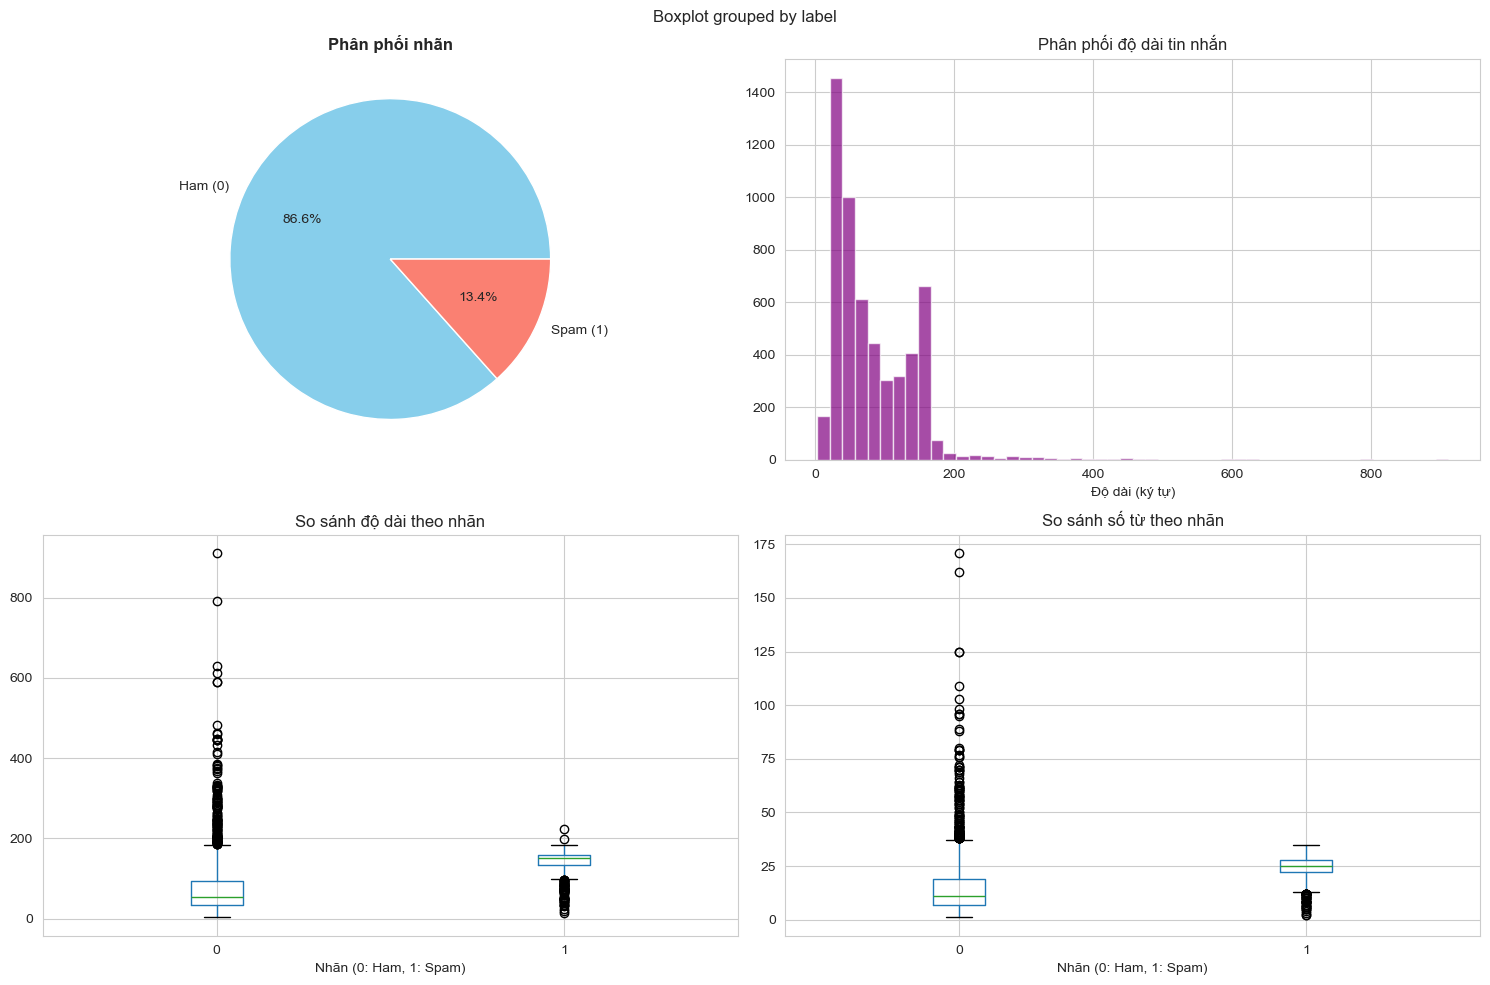


 Tỷ lệ mất cân bằng lớp: 6.46
Dữ liệu có vấn đề mất cân bằng lớp nghiêm trọng

 Hoàn thành khám phá dữ liệu


In [9]:
# Đọc và khám phá dữ liệu
df = pd.read_csv('train.csv')

print("THÔNG TIN CƠ BẢN VỀ DỮ LIỆU")
print("="*50)
print(f"Kích thước dữ liệu: {df.shape[0]} dòng, {df.shape[1]} cột")
print(f"Dữ liệu thiếu: {df.isnull().sum().sum()} values")

# Phân tích phân phối nhãn
print("\nPhân phối nhãn:")
label_counts = df['label'].value_counts()
print(label_counts)
label_percentages = df['label'].value_counts(normalize=True) * 100
for label, percentage in label_percentages.items():
    label_name = "Ham (Không rác)" if label == 0 else "Spam (Rác)"
    print(f"{label_name}: {percentage:.2f}%")

# Phân tích độ dài tin nhắn
df['length'] = df['sms'].apply(len)
df['word_count'] = df['sms'].apply(lambda x: len(x.split()))

print(f"\nThống kê độ dài tin nhắn:")
print(df['length'].describe())

print(f"\nSo sánh độ dài theo nhãn:")
length_stats = df.groupby('label')['length'].agg(['mean', 'std'])
print(length_stats)

# Trực quan hóa
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Phân phối nhãn
axes[0, 0].pie(label_counts.values, labels=['Ham (0)', 'Spam (1)'], 
               autopct='%1.1f%%', colors=['skyblue', 'salmon'])
axes[0, 0].set_title('Phân phối nhãn', fontweight='bold')

# Phân phối độ dài
df['length'].hist(bins=50, alpha=0.7, color='purple', ax=axes[0, 1])
axes[0, 1].set_title('Phân phối độ dài tin nhắn')
axes[0, 1].set_xlabel('Độ dài (ký tự)')

# So sánh độ dài theo nhãn
df.boxplot(column='length', by='label', ax=axes[1, 0])
axes[1, 0].set_title('So sánh độ dài theo nhãn')
axes[1, 0].set_xlabel('Nhãn (0: Ham, 1: Spam)')

# So sánh số từ theo nhãn
df.boxplot(column='word_count', by='label', ax=axes[1, 1])
axes[1, 1].set_title('So sánh số từ theo nhãn')
axes[1, 1].set_xlabel('Nhãn (0: Ham, 1: Spam)')

plt.tight_layout()
plt.show()

# Kiểm tra class imbalance
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"\n Tỷ lệ mất cân bằng lớp: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("Dữ liệu có vấn đề mất cân bằng lớp nghiêm trọng")

print(f"\n Hoàn thành khám phá dữ liệu")

In [10]:
# Khởi tạo công cụ tiền xử lý
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def advanced_preprocess_text(text):
    """Hàm tiền xử lý văn bản nâng cao"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Xử lý URL, email, số điện thoại, tiền
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', ' EMAIL ', text)
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', ' PHONE ', text)
    text = re.sub(r'\$\d+|\d+\$', ' MONEY ', text)
    
    # Xử lý từ lặp và chuyển về chữ thường
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = text.lower()
    
    # Giữ lại một số ký tự đặc biệt quan trọng
    text = re.sub(r'[^\w\s!?$%]', ' ', text)
    text = re.sub(r'\b\d+\b', ' NUM ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization và xử lý
    tokens = word_tokenize(text)
    processed_tokens = []
    
    for word in tokens:
        if (word.lower() not in stop_words and 
            len(word) > 1 and 
            not word.isdigit()):
            processed_tokens.append(stemmer.stem(word))
    
    return ' '.join(processed_tokens)

def extract_manual_features(text):
    """Trích xuất các features thủ công"""
    if pd.isna(text):
        text = ""
    text = str(text)
    
    return {
        'length': len(text),
        'word_count': len(text.split()),
        'num_caps': sum(c.isupper() for c in text),
        'num_exclamations': text.count('!'),
        'num_questions': text.count('?'),
        'num_dollars': text.count('$'),
        'caps_ratio': sum(c.isupper() for c in text) / len(text) if len(text) > 0 else 0,
        'has_url': 1 if any(url in text.lower() for url in ['http', 'www', '.com']) else 0,
        'has_phone': 1 if re.search(r'\d{3}[-.]?\d{3}[-.]?\d{4}', text) else 0,
        'has_money': 1 if '$' in text else 0
    }

print(" ÁP DỤNG TIỀN XỬ LÝ VĂN BẢN")
print("="*35)

# Áp dụng tiền xử lý
start_time = time.time()
df['processed_sms'] = df['sms'].apply(advanced_preprocess_text)

# Trích xuất manual features
manual_features_list = df['sms'].apply(extract_manual_features)
manual_features_df = pd.DataFrame(manual_features_list.tolist())

processing_time = time.time() - start_time
print(f" Thời gian tiền xử lý: {processing_time:.2f} giây")

# Hiển thị ví dụ
idx = 10
print(f"\n VÍ DỤ TIỀN XỬ LÝ:")
print(f"Gốc: '{df['sms'].iloc[idx]}'")
print(f"Xử lý: '{df['processed_sms'].iloc[idx]}'")

# So sánh độ dài
df['processed_length'] = df['processed_sms'].apply(len)
reduction = df['length'] - df['processed_length']
print(f"\nĐộ giảm trung bình: {reduction.mean():.1f} ký tự ({reduction.mean()/df['length'].mean()*100:.1f}%)")

print(f"\nManual Features được tạo: {list(manual_features_df.columns)}")
print("Hoàn thành tiền xử lý văn bản")

 ÁP DỤNG TIỀN XỬ LÝ VĂN BẢN
 Thời gian tiền xử lý: 3.99 giây

 VÍ DỤ TIỀN XỬ LÝ:
Gốc: 'I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
'
Xử lý: 'gon na home soon want talk stuff anymor tonight cri enough today'

Độ giảm trung bình: 33.7 ký tự (41.3%)

Manual Features được tạo: ['length', 'word_count', 'num_caps', 'num_exclamations', 'num_questions', 'num_dollars', 'caps_ratio', 'has_url', 'has_phone', 'has_money']
Hoàn thành tiền xử lý văn bản


VECTOR HÓA VĂN BẢN VÀ SO SÁNH 3 PHƯƠNG PHÁP
Chia dữ liệu: Train 4459, Test 1115

Vector hóa với BoW...
 BoW: 0.38s, Shape: (4459, 5010)

 Vector hóa với TF-IDF...
 TF-IDF: 0.38s, Shape: (4459, 5010)

 Vector hóa với Sentence Embeddings...
 Embeddings: 31.33s, Shape: (4459, 394)


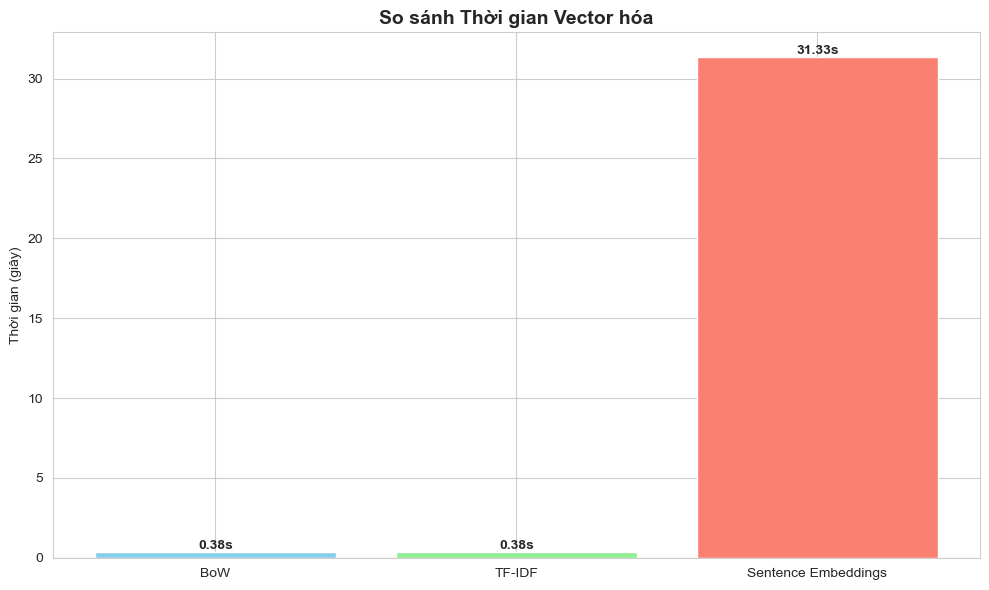

 Hoàn thành vector hóa với 3 phương pháp


In [11]:
print("VECTOR HÓA VĂN BẢN VÀ SO SÁNH 3 PHƯƠNG PHÁP")
print("="*50)

# Chia tập train/test
X_text = df['processed_sms']
X_manual = manual_features_df
y = df['label']

X_text_train, X_text_test, X_manual_train, X_manual_test, y_train, y_test = train_test_split(
    X_text, X_manual, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Chia dữ liệu: Train {len(X_text_train)}, Test {len(X_text_test)}")

# Chuẩn hóa manual features
scaler = StandardScaler()
X_manual_train_scaled = scaler.fit_transform(X_manual_train)
X_manual_test_scaled = scaler.transform(X_manual_test)

vectorization_times = {}
vector_data = {}

# 1. Bag-of-Words với hyperparameters tối ưu
print("\nVector hóa với BoW...")
start_time = time.time()
bow_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2)
)
X_train_bow = bow_vectorizer.fit_transform(X_text_train)
X_test_bow = bow_vectorizer.transform(X_text_test)

# Kết hợp với manual features
X_train_bow_manual = hstack([X_train_bow, csr_matrix(X_manual_train_scaled)])
X_test_bow_manual = hstack([X_test_bow, csr_matrix(X_manual_test_scaled)])

vectorization_times['BoW'] = time.time() - start_time
vector_data['BoW'] = (X_train_bow_manual, X_test_bow_manual)
print(f" BoW: {vectorization_times['BoW']:.2f}s, Shape: {X_train_bow_manual.shape}")

# 2. TF-IDF với hyperparameters tối ưu
print("\n Vector hóa với TF-IDF...")
start_time = time.time()
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    sublinear_tf=True
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_text_train)
X_test_tfidf = tfidf_vectorizer.transform(X_text_test)

# Kết hợp với manual features
X_train_tfidf_manual = hstack([X_train_tfidf, csr_matrix(X_manual_train_scaled)])
X_test_tfidf_manual = hstack([X_test_tfidf, csr_matrix(X_manual_test_scaled)])

vectorization_times['TF-IDF'] = time.time() - start_time
vector_data['TF-IDF'] = (X_train_tfidf_manual, X_test_tfidf_manual)
print(f" TF-IDF: {vectorization_times['TF-IDF']:.2f}s, Shape: {X_train_tfidf_manual.shape}")

# 3. Sentence Embeddings (nếu có)
if EMBEDDINGS_AVAILABLE:
    print("\n Vector hóa với Sentence Embeddings...")
    start_time = time.time()
    try:
        model = SentenceTransformer('all-MiniLM-L6-v2')
        X_train_emb = model.encode(X_text_train.tolist(), show_progress_bar=False)
        X_test_emb = model.encode(X_text_test.tolist(), show_progress_bar=False)
        
        # Kết hợp với manual features
        X_train_emb_manual = np.hstack([X_train_emb, X_manual_train_scaled])
        X_test_emb_manual = np.hstack([X_test_emb, X_manual_test_scaled])
        
        vectorization_times['Sentence Embeddings'] = time.time() - start_time
        vector_data['Sentence Embeddings'] = (X_train_emb_manual, X_test_emb_manual)
        print(f" Embeddings: {vectorization_times['Sentence Embeddings']:.2f}s, Shape: {X_train_emb_manual.shape}")
    except Exception as e:
        print(f" Lỗi Embeddings: {e}")
        EMBEDDINGS_AVAILABLE = False

# Trực quan hóa thời gian vector hóa
plt.figure(figsize=(10, 6))
methods = list(vectorization_times.keys())
times = list(vectorization_times.values())
colors = ['skyblue', 'lightgreen', 'salmon'][:len(methods)]

bars = plt.bar(methods, times, color=colors)
plt.title('So sánh Thời gian Vector hóa', fontsize=14, fontweight='bold')
plt.ylabel('Thời gian (giây)')

for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f" Hoàn thành vector hóa với {len(vector_data)} phương pháp")

 HUẤN LUYỆN MÔ HÌNH NAIVE BAYES VỚI GRID SEARCH
 Tìm kiếm hyperparameters tối ưu...
 Best alpha: 0.01, Best CV F1: 0.9416

 Huấn luyện BoW...
 BoW: 0.015s

 Huấn luyện TF-IDF...
 TF-IDF: 0.014s

 Huấn luyện Sentence Embeddings...
 Sentence Embeddings: 0.065s

 Đã huấn luyện thành công 3 mô hình!


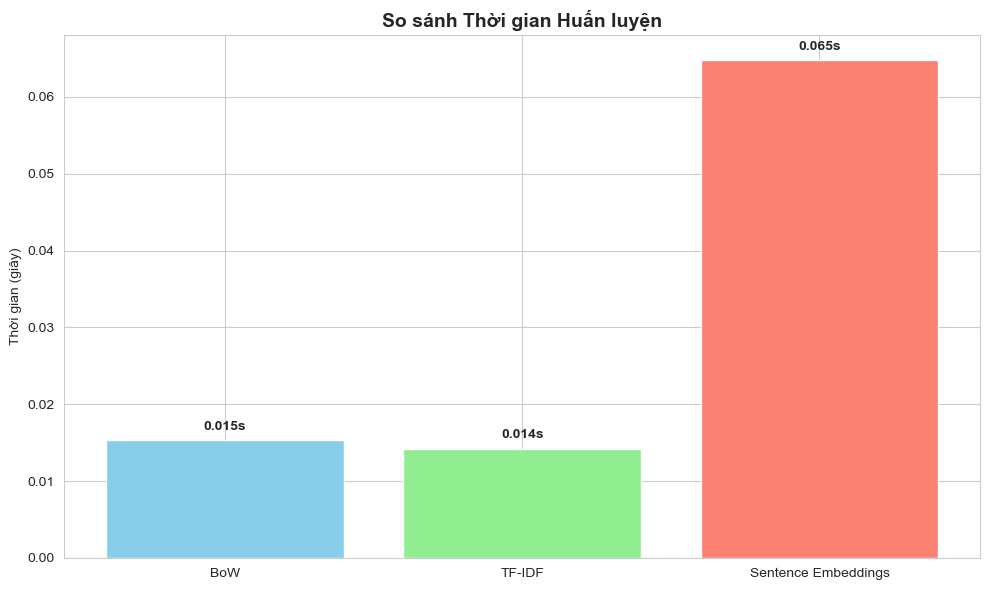

 Hoàn thành huấn luyện mô hình


In [15]:
print(" HUẤN LUYỆN MÔ HÌNH NAIVE BAYES VỚI GRID SEARCH")
print("="*55)

#  Sử dụng CountVectorizer cho MultinomialNB (BoW)
# Nếu muốn dùng TF-IDF, chỉ dùng ComplementNB hoặc GaussianNB

# 1️ Chuẩn hóa TF-IDF để MultinomialNB không bị lỗi
# Đảm bảo không âm
X_train_tfidf_manual_nonneg = X_train_tfidf_manual.copy()
X_train_tfidf_manual_nonneg[X_train_tfidf_manual_nonneg < 0] = 0

print(" Tìm kiếm hyperparameters tối ưu...")
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}

grid_search = GridSearchCV(
    MultinomialNB(), 
    param_grid, 
    cv=5, 
    scoring='f1',
    n_jobs=-1
)

# Dùng phiên bản không âm
grid_search.fit(X_train_tfidf_manual_nonneg, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f" Best alpha: {best_alpha}, Best CV F1: {grid_search.best_score_:.4f}")

# 2️ Huấn luyện các mô hình
models = {}
training_times = {}

for method, (X_train_vec, X_test_vec) in vector_data.items():
    print(f"\n Huấn luyện {method}...")
    start_time = time.time()
    
    if method == 'Sentence Embeddings':
        # Sử dụng GaussianNB cho embeddings
        model = GaussianNB()
        model.fit(X_train_vec, y_train)
    else:
        # MultinomialNB với alpha tối ưu
        # Đảm bảo dữ liệu không âm
        X_train_vec_nonneg = X_train_vec.copy()
        X_train_vec_nonneg[X_train_vec_nonneg < 0] = 0
        
        model = MultinomialNB(alpha=best_alpha)
        model.fit(X_train_vec_nonneg, y_train)
    
    training_times[method] = time.time() - start_time
    models[method] = model
    
    print(f" {method}: {training_times[method]:.3f}s")

print(f"\n Đã huấn luyện thành công {len(models)} mô hình!")

# 3️ Trực quan hóa thời gian huấn luyện
plt.figure(figsize=(10, 6))
methods = list(training_times.keys())
times = list(training_times.values())
colors = ['skyblue', 'lightgreen', 'salmon'][:len(methods)]

bars = plt.bar(methods, times, color=colors)
plt.title('So sánh Thời gian Huấn luyện', fontsize=14, fontweight='bold')
plt.ylabel('Thời gian (giây)')

for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{time_val:.3f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(" Hoàn thành huấn luyện mô hình")


 ĐÁNH GIÁ VÀ PHÂN TÍCH KẾT QUẢ

 Đánh giá BoW...
   Accuracy:  0.9901
   Precision: 0.9726
   Recall:    0.9530
   F1-score:  0.9627

 Đánh giá TF-IDF...
   Accuracy:  0.9821
   Precision: 0.9640
   Recall:    0.8993
   F1-score:  0.9306

 Đánh giá Sentence Embeddings...
   Accuracy:  0.9704
   Precision: 0.8625
   Recall:    0.9262
   F1-score:  0.8932

 MÔ HÌNH TỐT NHẤT: BoW
 F1-Score: 0.9627

 BẢNG SO SÁNH CHI TIẾT:


,accuracy,precision,recall,f1
BoW,0.9901,0.9726,0.9530,0.9627
TF-IDF,0.9821,0.9640,0.8993,0.9306
Sentence Embeddings,0.9704,0.8625,0.9262,0.8932


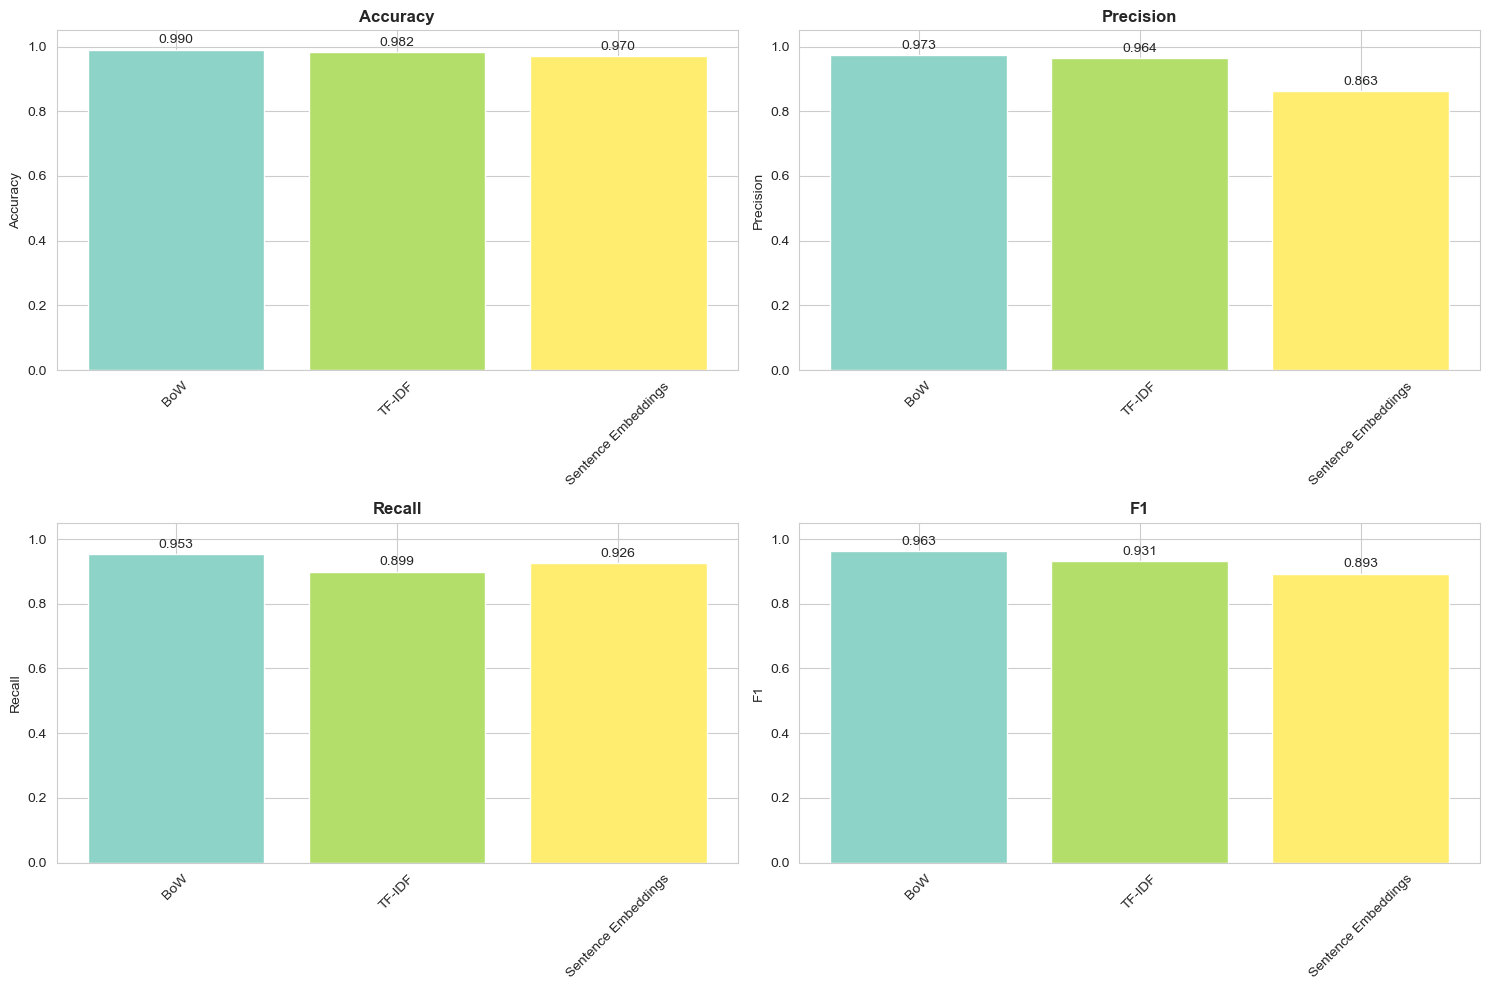

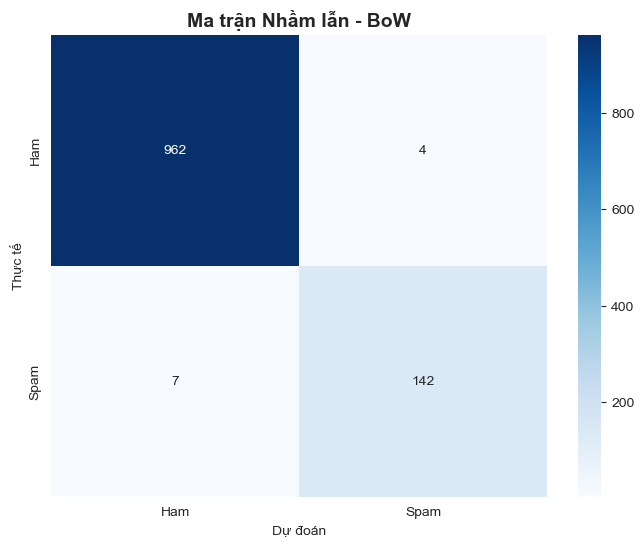


 PHÂN TÍCH FEATURES QUAN TRỌNG - BoW
--------------------------------------------------
 Top 15 từ quan trọng cho SPAM detection:
 1. claim               : +9.8161
 2. prize               : +9.5602
 3. tone                : +9.3266
 4. num prize           : +9.1337
 5. num cash            : +9.1337
 6. 150p                : +9.1122
 7. guarante            : +8.9472
 8. cs                  : +8.9212
 9. num claim           : +8.8100
10. landlin             : +8.6849
11. rington             : +8.6510
12. 150ppm              : +8.5796
13. cash num            : +8.5419
14. stop num            : +8.5419
15. box num             : +8.5027


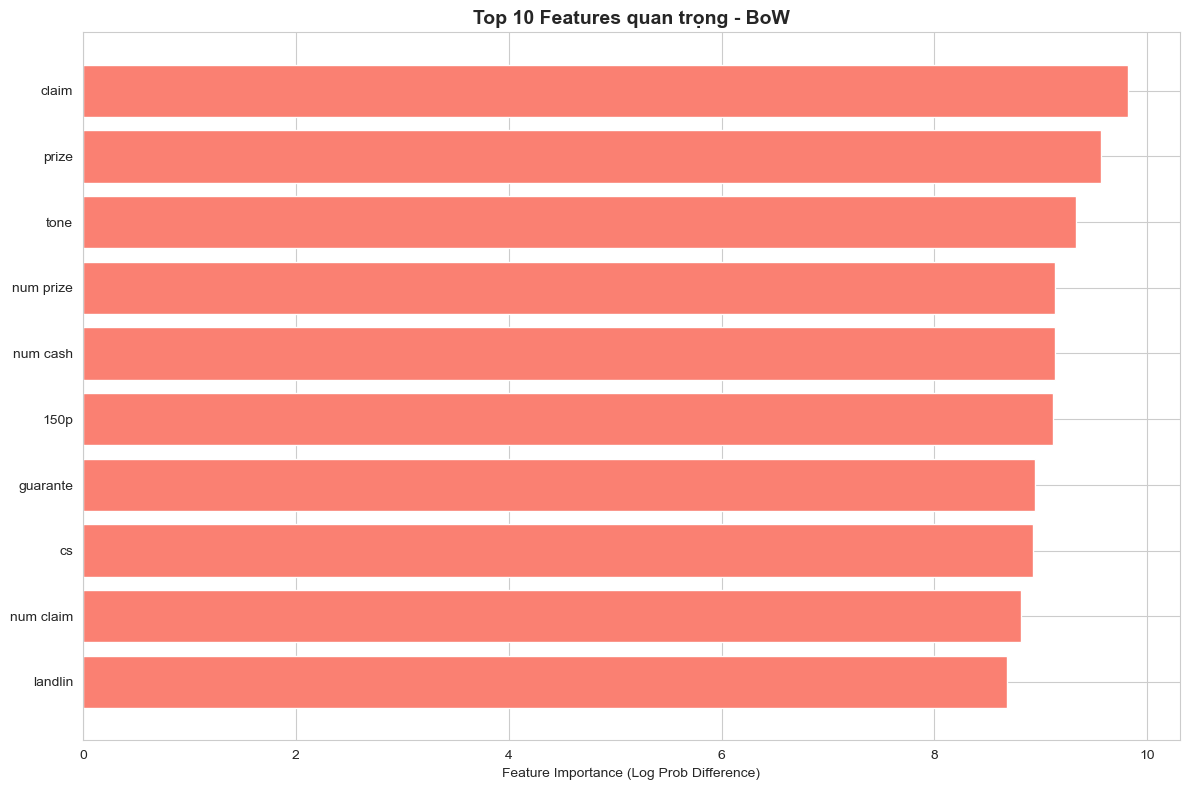


 TÓM TẮT KẾT QUẢ CUỐI CÙNG
 Mô hình tốt nhất: BoW (F1: 0.9627)
 Tổng số mô hình đã test: 3
 Tổng thời gian xử lý: 32.19s
 Hiệu suất xuất sắc!

 HOÀN THÀNH PHÂN TÍCH SPAM DETECTION VỚI NAIVE BAYES!


In [16]:
print(" ĐÁNH GIÁ VÀ PHÂN TÍCH KẾT QUẢ")
print("="*40)

# Đánh giá các mô hình
results = {}
predictions = {}

for method, model in models.items():
    print(f"\n Đánh giá {method}...")
    
    # Lấy dữ liệu test tương ứng
    _, X_test_vec = vector_data[method]
    
    # Dự đoán
    y_pred = model.predict(X_test_vec)
    predictions[method] = y_pred
    
    # Tính toán metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results[method] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-score:  {f1:.4f}")

# Tìm mô hình tốt nhất
best_method = max(results, key=lambda x: results[x]['f1'])
best_f1 = results[best_method]['f1']

print(f"\n MÔ HÌNH TỐT NHẤT: {best_method}")
print(f" F1-Score: {best_f1:.4f}")

# So sánh trực quan
comparison_df = pd.DataFrame(results).T
print(f"\n BẢNG SO SÁNH CHI TIẾT:")
display(comparison_df.round(4))

# Vẽ biểu đồ so sánh metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
metrics = ['accuracy', 'precision', 'recall', 'f1']
colors = plt.cm.Set3(np.linspace(0, 1, len(results)))

for i, metric in enumerate(metrics):
    methods = list(results.keys())
    values = [results[method][metric] for method in methods]
    
    bars = axes[i].bar(methods, values, color=colors)
    axes[i].set_title(f'{metric.capitalize()}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_ylim(0, 1.05)
    
    for bar, value in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10)
    
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Ma trận nhầm lẫn cho mô hình tốt nhất
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, predictions[best_method])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title(f'Ma trận Nhầm lẫn - {best_method}', fontsize=14, fontweight='bold')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

# Phân tích features quan trọng (nếu là BoW hoặc TF-IDF)
if best_method in ['BoW', 'TF-IDF']:
    print(f"\n PHÂN TÍCH FEATURES QUAN TRỌNG - {best_method}")
    print("-" * 50)
    
    vectorizer = bow_vectorizer if best_method == 'BoW' else tfidf_vectorizer
    feature_names = vectorizer.get_feature_names_out()
    model = models[best_method]
    
    # Tính feature importance
    feature_log_probs = model.feature_log_prob_
    n_text_features = len(feature_names)
    feature_importance = feature_log_probs[1, :n_text_features] - feature_log_probs[0, :n_text_features]
    
    # Top features cho spam
    top_spam_indices = feature_importance.argsort()[-15:][::-1]
    
    print(" Top 15 từ quan trọng cho SPAM detection:")
    for i, idx in enumerate(top_spam_indices):
        print(f"{i+1:2d}. {feature_names[idx]:20s}: {feature_importance[idx]:+.4f}")
    
    # Trực quan hóa
    plt.figure(figsize=(12, 8))
    top_features = [feature_names[i] for i in top_spam_indices[:10]]
    top_scores = [feature_importance[i] for i in top_spam_indices[:10]]
    
    plt.barh(range(len(top_features)), top_scores, color='salmon')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance (Log Prob Difference)')
    plt.title(f'Top 10 Features quan trọng - {best_method}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Báo cáo tóm tắt cuối cùng
print(f"\n TÓM TẮT KẾT QUẢ CUỐI CÙNG")
print("="*40)
print(f" Mô hình tốt nhất: {best_method} (F1: {best_f1:.4f})")
print(f" Tổng số mô hình đã test: {len(models)}")
print(f" Tổng thời gian xử lý: {sum(vectorization_times.values()) + sum(training_times.values()):.2f}s")

# Đánh giá hiệu suất
if best_f1 > 0.95:
    print(" Hiệu suất xuất sắc!")
elif best_f1 > 0.90:
    print(" Hiệu suất rất tốt!")
elif best_f1 > 0.85:
    print(" Hiệu suất tốt!")
else:
    print(" Hiệu suất cần cải thiện!")

print("\n HOÀN THÀNH PHÂN TÍCH SPAM DETECTION VỚI NAIVE BAYES!")